# EEG to Image Generation
Robert Sato, Alexander Cardaras
<br>UC Santa Cruz
## Version Info
### Updated: 4/27/21

## Issues:
- images saved as flat 1D array (64x64x3)
    - try using this flat image as input to the network and simply reshape at the input for CNN
    - not sure if it is faster to reshape before giving the image as input to the CNN or to reshape in the CNN after reading the input
- poor LSTM performance (~20%)

## General Notes
- 55-95Hz frequency range had the best performance
- try different normalization
- try different regularization
- try different models

## Revisions
EEG Classification
- added normalization
    - centered around 0 and sigmoid function applied
    - do not re-normalize each time. load the normalized data
- added linear normalization [0, 1]
- added l1 regularization at LSTM layer
    - tried 0.001 and 0.0001 (both ~20% test accuracy still)
- ThoughtViz CNN works the best (~30%)

Image Generation
- added AC-GAN for 64x64 RGB images
- switched Conv2DTranspose layers to UpSampling with Bilinear Interpolation

# Directions:
- **Execute** mount drive cell
- **Skip** load, convert and save data to Numpy files section
- **Execute** cells starting from **Classify the EEG wave data section**

**Complete the following steps before running the cells below**

1.
Change runtime to GPU 

>Runtime > Change runtime type > GPU

2.
For each of the following link, add a Google Drive shortcut to your Drive root folder(My Drive):

>https://drive.google.com/drive/folders/1z8wcew5R7GCeu5s7SSsWw8bUcx1urVmk?usp=sharing

**Mount drive**

In [31]:
from google.colab import drive
drive.mount("/content/gdrive")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# Load, convert and save data to Numpy files
- only executed once to generate .npy files
- load the .npy files directly for future use

In [ ]:
import torch
import numpy as np
from numpy import save
from numpy import load

In [ ]:
# use the default data_path
# eeg_55_95_std.pth - saved
# eeg_14_70_std.pth - saved
# eeg_5_95_std.pth - saved

raw_data_path = "/content/gdrive/MyDrive/EEG2Image/eeg_55_95_std.pth"
save_data_path = "/content/gdrive/MyDrive/EEG2Image/data/"

In [ ]:
# load eeg data from .pth files
loaded = torch.load(raw_data_path)
data = loaded['dataset']        
labels = loaded["labels"]
images = loaded["images"]
size = len(data)
print(size)

11965


In [ ]:
# convert data tensors to np
eeg_data = []
labels = []

# crop the first 20ms and last 40ms out
time_low = 20
time_high = 460

verbose = False # set to True to print information on the data

for i in range(size):
    if verbose:
        data_i = data[i]
        print("Keys stored in each data[i] object:", data_i.keys())

        eeg_i = data[i]["eeg"]
        print("Shape of data[i][\"eeg\"]:", eeg_i.shape)
        print("Type of data[i][\"eeg\"]:", eeg_i.type)
        print()

        eeg_f = data[i]["eeg"].float() # simply converts to float
        print("Shape of data[i][\"eeg\"].float():", eeg_f.shape)
        print("Type of data[i][\"eeg\"].float():", eeg_f.type)
        print()

        eeg_t = data[i]["eeg"].float().t() # transposes the matrix
        print("Shape of data[i][\"eeg\"].float().t():", eeg_t.shape)
        print("Type of data[i][\"eeg\"].float().t():", eeg_t.type)
        print()

        image = data[i]["image"]
        print("image:", image)

        label = data[i]["label"]
        print("label:", label)

        subject = data[i]["subject"]
        print("subject:", subject)

    eeg = data[i]["eeg"].float().t()
    eeg = eeg[time_low:time_high,:] # trim the data to between 0.2s - 0.46s
    label = data[i]["label"]

    # convert from tensor to numpy
    eeg_data.append(eeg.numpy())
    labels.append(label)

eeg_data = np.asarray(eeg_data)
labels = np.asarray(labels)
print("Shape of EEG data:", eeg_data.shape)
print("Shape of labels:", labels.shape)

Shape of EEG data: (11965, 440, 128)
Shape of labels: (11965,)


### Information about the .pth file data
- 6 subjects
- 40 image classes
- 50 images per class

6 subjects * 40 classes * 50 images/class = 12,000 segments
- each image (segment) = .5 ms @ 1kHz = 500 samples during the segment
- each sample = 128 channels

each segment = 128 * 500 voltage values

In [ ]:
save("/content/gdrive/MyDrive/EEG2Image/data/eeg_55_95.npy", eeg_data)
save("/content/gdrive/MyDrive/EEG2Image/data/labels_55_95.npy", labels)

In [ ]:
eeg_data = load("/content/gdrive/MyDrive/EEG2Image/data/eeg_55_95.npy")
labels = load("/content/gdrive/MyDrive/EEG2Image/data/labels_55_95.npy")

In [ ]:
print(eeg_data.shape)

(11965, 440, 128)


# Classify the EEG wave data
- load the data
- build a model
- train the model
- evaluate
- predict

In [ ]:
import numpy as np
from numpy import save, load
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, BatchNormalization, Conv2D, MaxPooling2D, Flatten
from keras.utils import to_categorical
from keras.regularizers import l1, l2
from sklearn.model_selection import train_test_split
from keras.utils.vis_utils import plot_model

### Load the data

In [ ]:
# options for data separated by frequency bands
# eeg_55_95.npy
# eeg_14_70.npy
# eeg_5_95.npy

print("Input which subset of data to use. Normalized sigmoid 55-95Hz (0), 14-70Hz (1), 55-95Hz (2), 5-95Hz (3), norm linear 55-95Hz(_)")
x = input()
x = int(x)

labels = load("/content/gdrive/MyDrive/EEG2Image/data/labels_5_95.npy")
if x == 0:
    data = load("/content/gdrive/MyDrive/EEG2Image/data/eeg_norm_sigmoid_55_95.npy")
    print("Finished loading sigmoid normalized 55-95Hz data")
elif x == 1:
    data = load("/content/gdrive/MyDrive/EEG2Image/data/eeg_14_70.npy")
    print("Finished loading 14-70Hz data")
elif x == 2:
    data = load("/content/gdrive/MyDrive/EEG2Image/data/eeg_55_95.npy")
    print("Finished loading 55-95Hz data")
elif x == 3:
    data = load("/content/gdrive/MyDrive/EEG2Image/data/eeg_5_95.npy")
    print("Finished loading 5-95Hz data")
else:
    data = load("/content/gdrive/MyDrive/EEG2Image/data/eeg_norm_linear_55_95.npy")
    print("Finished loading linear normalized 55-95Hz data")

Input which subset of data to use. Normalized sigmoid 55-95Hz (0), 14-70Hz (1), 55-95Hz (2), 5-95Hz (3), norm linear 55-95Hz(_)
2
Finished loading 55-95Hz data


In [ ]:
print("Data shape:", data.shape)
print("Labels shape:", labels.shape)

Data shape: (11965, 440, 128)
Labels shape: (11965,)


### Restrict data to 10 classes?

In [ ]:
# only use for restricting to 10 classes
data_10 = []
labels_10 = []

for i in range(len(labels)):
    if labels[i] < 10:
        data_10.append(data[i])
        labels_10.append(labels[i])

data_10 = np.asarray(data_10)
labels_10 = np.asarray(labels_10)

print(data_10.shape)
print(labels_10.shape)

data = data_10
labels = labels_10

## Normalize the data (if not already normalized)

### Mean 0, sigmoid

In [ ]:
# transpose the data to channels on the first axis to normalize
data = data.transpose(2, 0, 1)
print("Data shape:", data.shape)

Data shape: (128, 11965, 440)


In [ ]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

# vectorie the function so it can be applied to np arrays
sigmoid_v = np.vectorize(sigmoid)

In [ ]:
def normalize_array(data):
    # compute the average
    avg = np.average(data)
    print("Average EEG reading:", avg)
    print("data[0][0] (before shifting):", data[0][0])
    # center the data around 0 by subtracting the average
    shifted = data - avg
    print("Shape of shifted data:", shifted.shape)
    print("shifted[0][0] (after shifting):", shifted[0][0])
    # apply sigmoid function to get values in the range 0 - 1
    return sigmoid_v(shifted)

def normalize_data(data):
    # expects array of arrays as input
    for i in range(len(data)):
        print("\nNormalizing channel", i)
        data[i] = normalize_array(data[i])

In [ ]:
normalize_data(data)

In [ ]:
# check normalization
print("min:", np.amin(data))
print("max:", np.amax(data))

min: 1.7935853e-31
max: 1.0


In [ ]:
# revert the data
data = data.transpose(1, 2, 0)
print("Data shape:", data.shape)

Data shape: (11965, 440, 128)


In [ ]:
save("/content/gdrive/MyDrive/EEG2Image/data/eeg_norm_sigmoid_55_95.npy", data)

In [ ]:
plt.figure(figsize=(20,20))
plt.plot(data[0])

### Linear Normalization - [min, max] -> [0, 1]

In [ ]:
# transpose the data to channels on the first axis to normalize
data = data.transpose(2, 0, 1)
print("Data shape:", data.shape)

Data shape: (128, 11965, 440)


In [ ]:
def normalize_data(data):
    # expects array of arrays as input
    for i in range(len(data)):
        min = np.amin(data[i])
        data[i] -= min
        # shift all values so min is 0
        # divide by new max
        max = np.amax(data[i])
        print("\nNormalizing channel", i, "\nMax:", max)
        data[i] /= max

In [ ]:
# check normalization
print("min:", np.amin(data))
print("max:", np.amax(data))

normalize_data(data)

print("After normalization:")
print("min:", np.amin(data))
print("max:", np.amax(data))

for channel in range(len(data)):
    print("Average EEG reading for channel i:", np.average(data[channel]))

min: -70.79585
max: 72.47691

Normalizing channel 0 
Max: 43.09008

Normalizing channel 1 
Max: 40.92071

Normalizing channel 2 
Max: 52.82456

Normalizing channel 3 
Max: 23.356005

Normalizing channel 4 
Max: 10.927322

Normalizing channel 5 
Max: 56.237

Normalizing channel 6 
Max: 67.69171

Normalizing channel 7 
Max: 35.436943

Normalizing channel 8 
Max: 43.188255

Normalizing channel 9 
Max: 17.634443

Normalizing channel 10 
Max: 34.000668

Normalizing channel 11 
Max: 16.651829

Normalizing channel 12 
Max: 25.444431

Normalizing channel 13 
Max: 12.618238

Normalizing channel 14 
Max: 55.49749

Normalizing channel 15 
Max: 51.34159

Normalizing channel 16 
Max: 14.752741

Normalizing channel 17 
Max: 14.113015

Normalizing channel 18 
Max: 16.144066

Normalizing channel 19 
Max: 24.502832

Normalizing channel 20 
Max: 15.731882

Normalizing channel 21 
Max: 17.543661

Normalizing channel 22 
Max: 13.646734

Normalizing channel 23 
Max: 13.906882

Normalizing channel 24 
Max: 

In [ ]:
# revert the data
data = data.transpose(1, 2, 0)
print("Data shape:", data.shape)

Data shape: (11965, 440, 128)


In [ ]:
save("/content/gdrive/MyDrive/EEG2Image/data/eeg_norm_linear_55_95.npy", data)

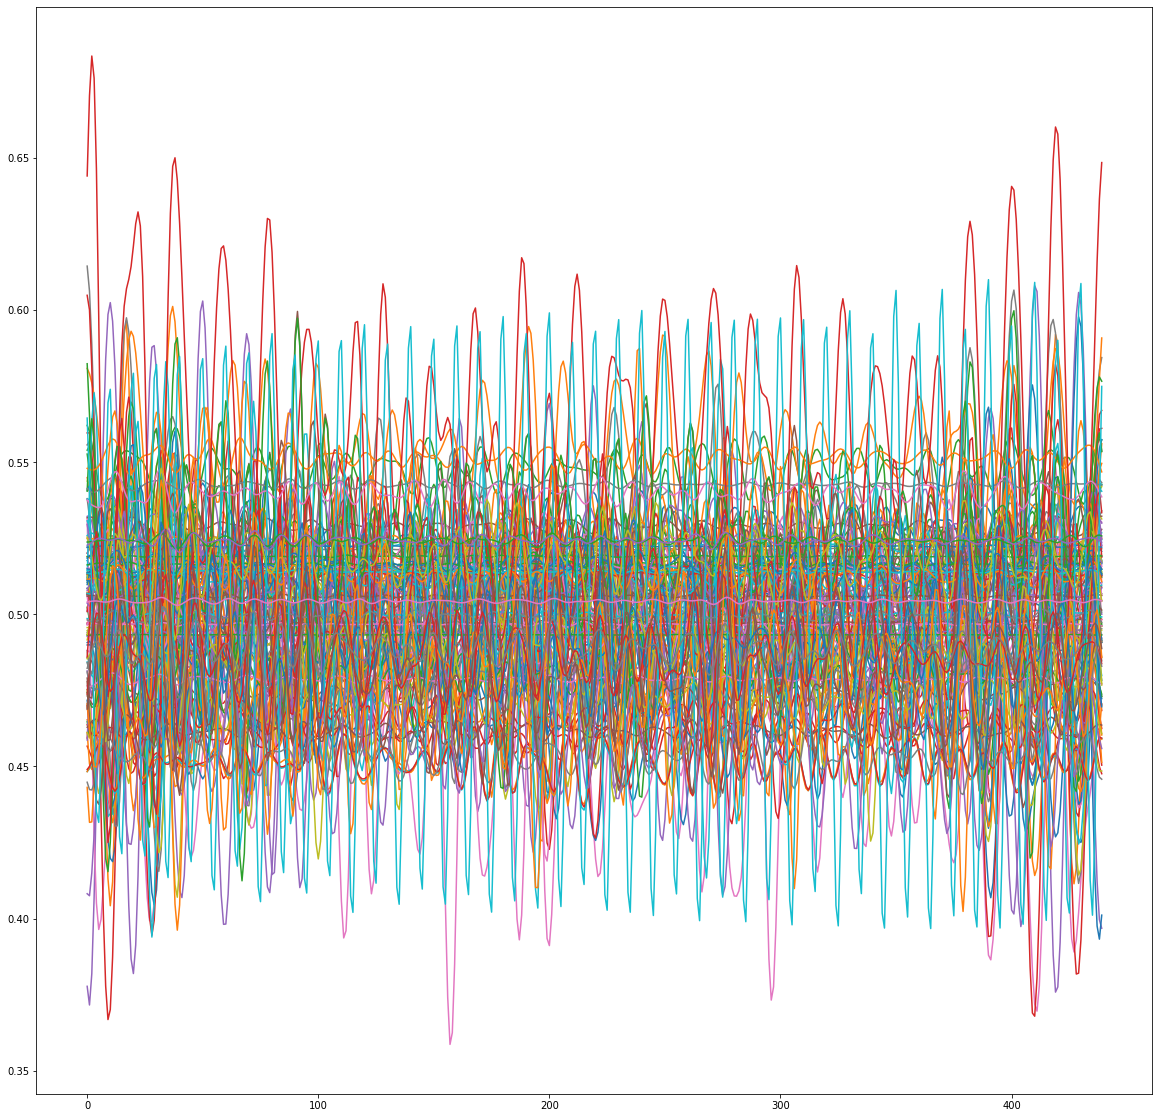

In [ ]:
plt.figure(figsize=(20,20))
plt.plot(data[0])

## EEG Classification

In [ ]:
# initialize training and test data
x_train, x_test, y_train, y_test = train_test_split(data, labels, test_size = 0.20, random_state = 10)
print('Shape of x_train:', x_train.shape)
print('Shape of y_train:', y_train.shape)
print('Shape of x_test:', x_test.shape)
print('Shape of y_test:', y_test.shape)

# one hot encode the labels
#y_train = to_categorical(y_train, 40)
#y_test = to_categorical(y_test, 40)

y_train = to_categorical(y_train, 40)
y_test = to_categorical(y_test, 40)

Shape of x_train: (9572, 440, 128)
Shape of y_train: (9572,)
Shape of x_test: (2393, 440, 128)
Shape of y_test: (2393,)


In [ ]:
# define parameters
BATCH_SIZE = 16
EPOCHS = 100

TIMESTEPS = len(data[0])
TOTAL_INPUTS = len(data)
DATA_POINTS = TOTAL_INPUTS * TIMESTEPS 
FEATURES = len(x_train[0][0])

print('TIMESTEPS =', TIMESTEPS)
print('TOTAL_INPUTS =', TOTAL_INPUTS)
print('DATA_POINTS =', DATA_POINTS)
print('FEATURES =', FEATURES)

TIMESTEPS = 440
TOTAL_INPUTS = 11965
DATA_POINTS = 5264600
FEATURES = 128


### LSTM Model

In [ ]:
# LSTM model
# reference: https://arxiv.org/pdf/1609.00344.pdf
model = Sequential()
model.add(LSTM(128, input_shape = (TIMESTEPS, FEATURES), activity_regularizer=l2(0.001))) 
model.add(Dense(128, activation='relu'))
model.add(Dense(40, activation='softmax'))

### CNN Model
This model is from the ThoughtViz paper
https://github.com/ptirupat/ThoughtViz/blob/24a4a8a7d3a3191bb0b45b7a2ba686ac7301875a/training/models/classification.py

In [ ]:
# reshape the input for CNN to (_, 128, 440)
x_train = x_train.transpose(0, 2, 1)
x_test = x_test.transpose(0, 2, 1)

In [ ]:
# reshape the input for CNN to (_, 128, 44, 1)
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], x_test.shape[2], 1)

In [ ]:
# ThoughtViz paper:
# https://github.com/ptirupat/ThoughtViz/blob/24a4a8a7d3a3191bb0b45b7a2ba686ac7301875a/training/models/classification.py
print(x_train.shape)

# define the CNN model for classification
def convolutional_encoder_model(channels, observations, num_classes):
    model = Sequential()
    #model.add(BatchNormalization(input_shape=(channels, observations, 1)))
    model.add(BatchNormalization(input_shape=(channels, observations, 1) )) # dont specify batch size
    model.add(Conv2D(32, (1, 4), activation='relu'))
    model.add(Conv2D(25, (channels, 1), activation='relu'))
    model.add(MaxPooling2D((1, 3)))
    model.add(Conv2D(50, (4, 25), activation='relu', data_format='channels_first'))
    model.add(MaxPooling2D((1, 3)))
    model.add(Conv2D(100, (50, 2), activation='relu'))
    model.add(Flatten())
    model.add(BatchNormalization())
    model.add(Dense(100, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dense(num_classes, activation='softmax'))
    return model
model = convolutional_encoder_model(FEATURES, TIMESTEPS, num_classes=40)

(9572, 128, 440, 1)


### Model Summary, Fit and Results

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization (BatchNo (None, 128, 440, 1)       4         
_________________________________________________________________
conv2d (Conv2D)              (None, 128, 437, 32)      160       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 1, 437, 25)        102425    
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 1, 145, 25)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 50, 142, 1)        5050      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 50, 47, 1)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 1, 46, 100)        1

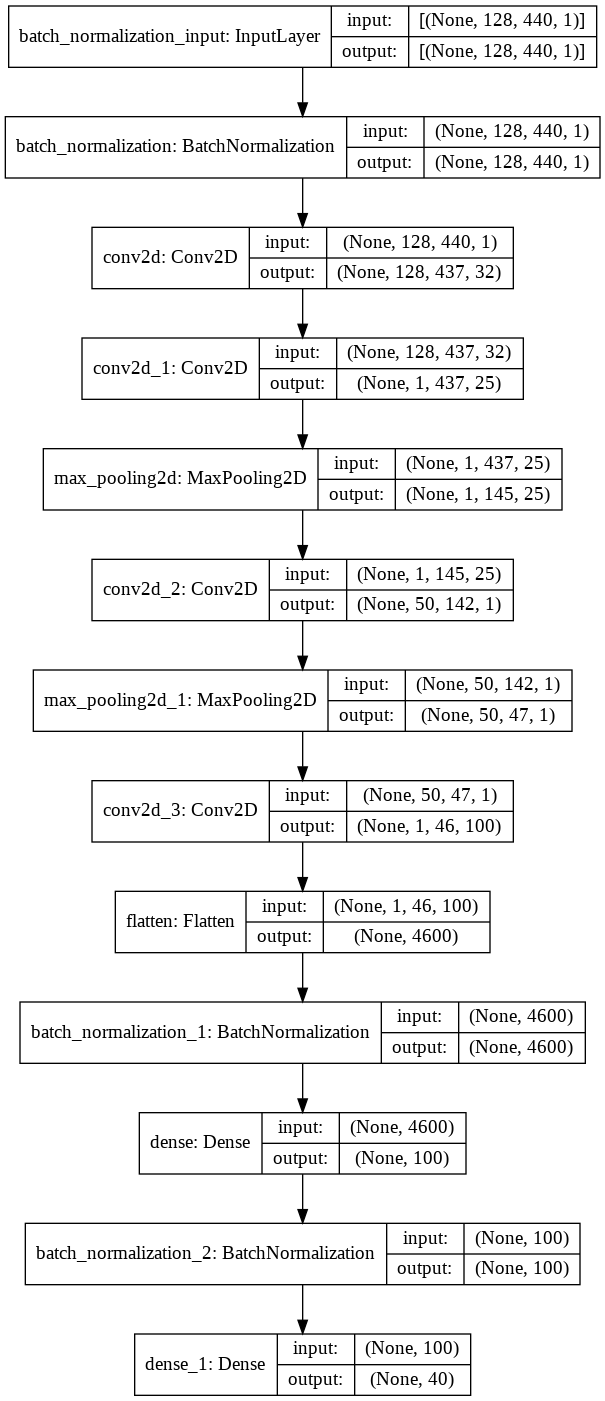

In [ ]:
model.summary()
plot_model(model, to_file='classifier_model.png', show_shapes=True, show_layer_names=True)

In [ ]:
# default schedule
#OPT = 'adam'
#OPT = 'SGD'
#ThoughtViz
OPT = keras.optimizers.SGD(lr=0.0001, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy', optimizer = OPT, metrics = ['accuracy'])

In [ ]:
my_callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=10),
    #tf.keras.callbacks.ModelCheckpoint(filepath='model.{epoch:02d}-{val_loss:.2f}.h5'),
    tf.keras.callbacks.TensorBoard(log_dir='./logs'),
]

In [ ]:
history = model.fit(
    x_train, 
    y_train,
    epochs=EPOCHS, 
    batch_size=BATCH_SIZE,
    validation_split=0.1,
    verbose=2,
    callbacks=my_callbacks)

Epoch 1/100
539/539 - 46s - loss: 3.6462 - accuracy: 0.0476 - val_loss: 3.5692 - val_accuracy: 0.0678
Epoch 2/100
539/539 - 10s - loss: 3.2671 - accuracy: 0.0919 - val_loss: 3.2536 - val_accuracy: 0.0929
Epoch 3/100
539/539 - 10s - loss: 3.0049 - accuracy: 0.1379 - val_loss: 3.1471 - val_accuracy: 0.1075
Epoch 4/100
539/539 - 10s - loss: 2.8175 - accuracy: 0.1716 - val_loss: 2.8855 - val_accuracy: 0.1367
Epoch 5/100
539/539 - 10s - loss: 2.6516 - accuracy: 0.2157 - val_loss: 2.6920 - val_accuracy: 0.1597
Epoch 6/100
539/539 - 10s - loss: 2.5082 - accuracy: 0.2391 - val_loss: 2.6215 - val_accuracy: 0.1848
Epoch 7/100
539/539 - 10s - loss: 2.3741 - accuracy: 0.2737 - val_loss: 2.4374 - val_accuracy: 0.2213
Epoch 8/100
539/539 - 10s - loss: 2.2547 - accuracy: 0.3031 - val_loss: 2.4934 - val_accuracy: 0.2286
Epoch 9/100
539/539 - 10s - loss: 2.1384 - accuracy: 0.3335 - val_loss: 2.2393 - val_accuracy: 0.2422
Epoch 10/100
539/539 - 10s - loss: 2.0398 - accuracy: 0.3623 - val_loss: 2.3911 - 

In [ ]:
train_loss,train_acc = model.evaluate(x_train,y_train)
test_loss, test_acc = model.evaluate(x_test,y_test)
print('Training set accuracy:', train_acc)
print('Test set accuracy:', test_acc)

300/300 [==============================] - 5s 14ms/step - loss: 0.8734 - accuracy: 0.7771


In [ ]:
#plt.figure(figsize = (10,10))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Number of epochs')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
# plot loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Number of epochs')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
num_predictions = 100
correct_pred = 0
pred = np.argmax(model.predict(x_test[0:num_predictions]), axis=-1)
print_count = 0

print("Predicted class : Class label")
for i in range(num_predictions):
    label = np.argmax(y_test[i])
    #print(pred[i], "=?", label)
    print("{:2s} : {:2s}".format(str(pred[i]), str(label)), end= "     ")
    
    print_count += 1
    if print_count == 5:
        print()
        print_count = 0

    if pred[i] == label:
        correct_pred += 1

print("\nTotal correct predictions:", correct_pred)
print("Percent correct:", correct_pred/num_predictions)

### Confusion matrix code reference:
https://towardsdatascience.com/confusion-matrix-for-your-multi-class-machine-learning-model-ff9aa3bf7826

In [ ]:
# convert from one hot to class number
Y_test = []
for y in y_test:
    Y_test.append(np.argmax(y))
y_test = np.asarray(Y_test)

# make predictions
y_pred = np.argmax(model.predict(x_test), axis=-1)

In [ ]:
import pandas as pd
from sklearn.metrics import confusion_matrix

confusion = confusion_matrix(y_test, y_pred)

df = pd.DataFrame(confusion)
def highlight_diag(df):
    a = np.full(df.shape, '', dtype='<U24')
    np.fill_diagonal(a, 'background-color: yellow')
    return pd.DataFrame(a, index=df.index, columns=df.columns)

df.style.apply(highlight_diag, axis=None)


In [ ]:
#importing accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
print('\nAccuracy: {:.2f}\n'.format(accuracy_score(y_test, y_pred)))

print('Micro Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='micro')))
print('Micro Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='micro')))
print('Micro F1-score: {:.2f}\n'.format(f1_score(y_test, y_pred, average='micro')))

print('Macro Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='macro')))
print('Macro Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='macro')))
print('Macro F1-score: {:.2f}\n'.format(f1_score(y_test, y_pred, average='macro')))

print('Weighted Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='weighted')))
print('Weighted Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='weighted')))
print('Weighted F1-score: {:.2f}'.format(f1_score(y_test, y_pred, average='weighted')))

In [ ]:
from sklearn.metrics import classification_report
print('\nClassification Report\n')
print(classification_report(y_test, y_pred))

# Loading Image Net dataset

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import collections

In [2]:
def array_to_image(img):
    return img.reshape(3, 64, 64).transpose(1, 2, 0) / np.float32(255)


def save_images(image_mapping_array, label_number):
    images = image_mapping_array[label_number]

    # Loop through all images for a specific label and save them
    for index, image in enumerate(images):
        img = array_to_image(image)
        plt.imsave("images/" + str(index) + ".png", img, format="png")


def load_mapping(path, as_dict=False):
    # Load image mapping file
    label2image64 = np.load(path, allow_pickle=True)
    if as_dict:
        return label2image64[()]
    else:
        # Create a numpy ready array of image mappings [[class 0 images], [class 1 images], ... , [class 39 images]]
        return list(collections.OrderedDict(sorted(label2image64[()].items())).values())

In [3]:
# only exec once to copy image_mapping.npy over to local
!ls /content/gdrive/MyDrive/EEG2Image/data/
!cp /content/gdrive/MyDrive/EEG2Image/data/image_mapping.npy /content/

eeg_14_70.npy  eeg_norm_linear_55_95.npy   image_mapping.npy  labels_55_95.npy
eeg_55_95.npy  eeg_norm_sigmoid_55_95.npy  images.npy	      labels_5_95.npy
eeg_5_95.npy   image_labels.npy		   labels_14_70.npy


In [4]:
def convert_data(data, image_shape=(64,64,3), scale=True):
    print("Converting data shape to 2D with 3 channels")
    if len(image_shape) != 3:
        print("Unexpected image_shape in convert_data")
        return -1
    # change the dimensions and scale
    # create new list to store the data in the correct format
    formatted_data = []
    count = 0
    for image in data:
        count += 1
        # convert from flat to 2D
        # formatted_data.append(array_to_image(image)) # that function changes bounds
        reshaped = image.reshape(3, 64, 64).transpose(1, 2, 0)
        formatted_data.append(reshaped)
    X = np.asarray(formatted_data)
    if scale:
        print("scaling values to the range [-1, 1]")
        X = X.astype('float32') # caution: storing lots of intermediate representation of image set
        X = (X - 127.5) / 127.5
    print("formatted shape:", X.shape)
    return X

In [5]:
# emulate the load_data() function but only return (images, labels)
# scale flag scales the input to [-1, 1] if true
def load_image_net_data(scale=True):
    mapping = load_mapping("image_mapping.npy", as_dict=False)
    # images stored as flat
    images = []
    num_images_per_class = 900
    for elem in mapping:
        images.append(np.asarray(elem[0:num_images_per_class])) # not all the same size so trim to 900 images per class
    images = np.asarray(images)
    num_classes = images.shape[0]
    print("shape of the data:", images.shape) # (40, 900, 12288) but want (900, 64, 64, 3)
    print("classes:", images.shape[0])
    print("images per class:", images.shape[1])
    print("pixel values in images:", images.shape[2])
    
    # append all classes into one list
    mapping = []
    for image_class in range(num_classes):
        for image in range(num_images_per_class):
            # append this image to one long new list
            mapping.append(images[image_class][image])
    mapping = np.asarray(mapping)
    print("shape after removing classes:", mapping.shape)

    data = convert_data(mapping, (64,64,3), scale)

    # create the labels
    labels = np.arange(0, 40, 1) # create labels 0 -> 39
    labels = np.repeat(labels, num_images_per_class) # repeat each label for num images per class
    return data, labels

In [6]:
printFlag = False
if printFlag:
    trainX, trainY = load_image_net_data(scale=False)
    print(trainX.shape)
    print(trainY.shape)
    print("min:", np.amin(trainX[0]))
    print("max:", np.amax(trainY[1]))
    images_per_class = 900
    print("Showing the first 10 images classes")
    plt.figure(figsize=(20, 20))
    # plot images from the training dataset
    for i in range(100):
    	# define subplot
    	plt.subplot(10, 10, 1 + i)
    	# turn off axis
    	plt.axis('off')
    	# plot raw pixel data
    	# every 10, skip rest of images in the class
    	#plt.imshow(array_to_image( trainX[i + ((i//10)*images_per_class)] ))
    	plt.imshow( trainX[i + ((i//10)*images_per_class)] )
    plt.show()

**done loading images**

# AC-GAN Modified for 64x64x3
Reference to the blogpost that details a base AC-GAN implementation<br>
https://machinelearningmastery.com/how-to-develop-an-auxiliary-classifier-gan-ac-gan-from-scratch-with-keras/
<br>
### What do I want? + How to implement?
- easily modify the generator. discriminator, training functions
    - create new define_generator functions (and discriminator)
**Where to save?**
    - timestamped folder on Google Drive
**What to save?**
- save the output of the models at checkpoints
- save the models at checkpoints
- visualize loss across epochs
- output a plot of the evolution of some images across training
    - first image of first 10 classes

### To Do:
- add noise at each layer
    - skip connections/new embeddings
- visualize the loss functions (create a function that does this)

### Progress
- change Conv2DTranspose to upsample + bilinear interp
- add functionality to save to a specific folder so i dont have to manually save across tests
    - simply copies generated*.png files to a specific folder

### Tried:
- changed to bilinear upsampling
    - tried 10 classes
    - tried 1 class

In [7]:
# example of fitting an auxiliary classifier gan (ac-gan) 
from numpy import zeros
from numpy import ones
from numpy import expand_dims
from numpy.random import randn
from numpy.random import randint
from keras.optimizers import Adam
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import UpSampling2D
from keras.layers import LeakyReLU
from keras.layers import BatchNormalization
from keras.layers import Dropout
from keras.layers import Embedding
from keras.layers import Activation
from keras.layers import Concatenate
from keras.initializers import RandomNormal
from matplotlib import pyplot
from keras.utils.vis_utils import plot_model

In [8]:
# define the standalone discriminator model
def define_discriminator(in_shape=(64,64,3), n_classes=1):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# image input
	in_image = Input(shape=in_shape)
	# downsample to 32x32
	fe = Conv2D(32, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(in_image)
	fe = LeakyReLU(alpha=0.2)(fe)
	fe = Dropout(0.5)(fe)
	# normal
	fe = Conv2D(64, (3,3), padding='same', kernel_initializer=init)(fe)
	fe = BatchNormalization()(fe)
	fe = LeakyReLU(alpha=0.2)(fe)
	fe = Dropout(0.5)(fe)
	# downsample to 16x16
	fe = Conv2D(128, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(fe)
	fe = BatchNormalization()(fe)
	fe = LeakyReLU(alpha=0.2)(fe)
	fe = Dropout(0.5)(fe)
	# downsample to 8x8
	fe = Conv2D(128, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(fe)
	fe = BatchNormalization()(fe)
	fe = LeakyReLU(alpha=0.2)(fe)
	fe = Dropout(0.5)(fe)
	# normal
	fe = Conv2D(256, (3,3), padding='same', kernel_initializer=init)(fe)
	fe = BatchNormalization()(fe)
	fe = LeakyReLU(alpha=0.2)(fe)
	fe = Dropout(0.5)(fe)
	# flatten feature maps
	fe = Flatten()(fe)
	# real/fake output
	out1 = Dense(1, activation='sigmoid')(fe)
	# class label output
	out2 = Dense(n_classes, activation='softmax')(fe)
	# define model
	model = Model(in_image, [out1, out2])
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss=['binary_crossentropy', 'sparse_categorical_crossentropy'], optimizer=opt)
	return model

In [9]:
def model_info(model, name):
    model.summary()
    plot_model(model, to_file=name+'.png', show_shapes=True, show_layer_names=True)

In [10]:
# size of the latent space
latent_dim = 100

In [11]:
# create the discriminator
discriminator = define_discriminator()
model_info(discriminator, "discriminator")

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 32, 32, 32)   896         input_1[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu (LeakyReLU)         (None, 32, 32, 32)   0           conv2d[0][0]                     
__________________________________________________________________________________________________
dropout (Dropout)               (None, 32, 32, 32)   0           leaky_re_lu[0][0]                
______________________________________________________________________________________________

In [14]:
# define the standalone generator model
def define_generator(latent_dim, n_classes=1):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# label input
	in_label = Input(shape=(1,))
	# embedding for categorical input
	li = Embedding(n_classes, 50)(in_label)
	# linear multiplication
	n_nodes = 8 * 8
	li = Dense(n_nodes, kernel_initializer=init)(li)
	# reshape to additional channel
	li = Reshape((8, 8, 1))(li)
	# image generator input
	in_lat = Input(shape=(latent_dim,))
	# foundation for 8x8 image
	n_nodes = 128 * 8 * 8
	gen = Dense(n_nodes, kernel_initializer=init)(in_lat)
	gen = Activation('relu')(gen)
	gen = Reshape((8, 8, 128))(gen)
	# merge image gen and label input
	merge = Concatenate()([gen, li])
	# upsample to 16x16
	gen = Conv2DTranspose(64, (5,5), strides=(2,2), padding='same', kernel_initializer=init)(merge)
	gen = BatchNormalization()(gen)
	gen = Activation('relu')(gen)
	# upsample to 32x32
	gen = Conv2DTranspose(32, (5,5), strides=(2,2), padding='same', kernel_initializer=init)(gen)
	gen = BatchNormalization()(gen)
	gen = Activation('relu')(gen)
	# upsample to 64x64
	gen = Conv2DTranspose(3, (5,5), strides=(2,2), padding='same', kernel_initializer=init)(gen)
	out_layer = Activation('tanh')(gen)
	# define model
	model = Model([in_lat, in_label], out_layer)
	return model

In [ ]:
# generator v2 - replace Conv2DTranspose layers with upsample + bilinear interpolation
def define_generator(latent_dim, n_classes=1):
    init = RandomNormal(stddev=0.02)
    in_label = Input(shape=(1,))
    li = Embedding(n_classes, 50)(in_label)
    n_nodes = 8 * 8
    li = Dense(n_nodes, kernel_initializer=init)(li)
    li = Reshape((8, 8, 1))(li)
    in_lat = Input(shape=(latent_dim,))
    n_nodes = 128 * 8 * 8
    gen = Dense(n_nodes, kernel_initializer=init)(in_lat)
    gen = Activation('relu')(gen)
    gen = Reshape((8, 8, 128))(gen)
    merge = Concatenate()([gen, li])
    # change to upsample + bilinear interp
    gen = UpSampling2D(size=(2,2),interpolation='bilinear')(merge) # to 16x16
    gen = BatchNormalization()(gen)
    gen = Activation('relu')(gen)
    gen = UpSampling2D(size=(2,2), interpolation='bilinear')(gen) # to 32x32
    gen = BatchNormalization()(gen)
    gen = Activation('relu')(gen)
    gen = UpSampling2D(size=(2,2), interpolation='bilinear')(gen) # to 64x64
    # use convolution layer to resize to 3 channels
    gen = Conv2D(3, (3,3), padding='same', kernel_initializer=init)(gen)
    out_layer = Activation('tanh')(gen)
    model = Model([in_lat, in_label], out_layer)
    return model

In [ ]:
# generator v3 - Conv2DT with random noise added between layers
def define_generator(latent_dim, n_classes=10):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# label input
	in_label = Input(shape=(1,))
	# embedding for categorical input
	li = Embedding(n_classes, 50)(in_label)
	# linear multiplication
	n_nodes = 8 * 8
	li = Dense(n_nodes, kernel_initializer=init)(li)
	# reshape to additional channel
	li = Reshape((8, 8, 1))(li)
	# image generator input
	in_lat = Input(shape=(latent_dim,))
	# foundation for 8x8 image
	n_nodes = 128 * 8 * 8
	gen = Dense(n_nodes, kernel_initializer=init)(in_lat)
	gen = Activation('relu')(gen)
	gen = Reshape((8, 8, 128))(gen)
	# merge image gen and label input
	merge = Concatenate()([gen, li])
	# upsample to 16x16
	gen = Conv2DTranspose(64, (5,5), strides=(2,2), padding='same', kernel_initializer=init)(merge)
	gen = BatchNormalization()(gen)
	gen = Activation('relu')(gen)
	# upsample to 32x32
	gen = Conv2DTranspose(32, (5,5), strides=(2,2), padding='same', kernel_initializer=init)(gen)
	gen = BatchNormalization()(gen)
	gen = Activation('relu')(gen)
	# upsample to 64x64
	gen = Conv2DTranspose(3, (5,5), strides=(2,2), padding='same', kernel_initializer=init)(gen)
	out_layer = Activation('tanh')(gen)
	# define model
	model = Model([in_lat, in_label], out_layer)
	return model

In [15]:
# create the generator
generator = define_generator(latent_dim)
model_info(generator, "generator")

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 100)]        0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
dense_5 (Dense)                 (None, 8192)         827392      input_5[0][0]                    
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 1, 50)        50          input_4[0][0]                    
____________________________________________________________________________________________

In [16]:
# define the combined generator and discriminator model, for updating the generator
def define_gan(g_model, d_model):
	# make weights in the discriminator not trainable
	for layer in d_model.layers:
		if not isinstance(layer, BatchNormalization):
			layer.trainable = False
	# connect the outputs of the generator to the inputs of the discriminator
	gan_output = d_model(g_model.output)
	# define gan model as taking noise and label and outputting real/fake and label outputs
	model = Model(g_model.input, gan_output)
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss=['binary_crossentropy', 'sparse_categorical_crossentropy'], optimizer=opt)
	return model

# load images
def load_real_samples():
	# load dataset
	(X, trainy) = load_image_net_data(scale=True)
	print(X.shape, trainy.shape)
	return [X, trainy]

# select real samples
def generate_real_samples(dataset, n_samples):
	# split into images and labels
	images, labels = dataset
	# choose random instances
	ix = randint(0, images.shape[0], n_samples)
	# select images and labels
	X, labels = images[ix], labels[ix]
	# generate class labels
	y = ones((n_samples, 1))
	return [X, labels], y

# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples, n_classes=1):
	# generate points in the latent space
	x_input = randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	z_input = x_input.reshape(n_samples, latent_dim)
	# generate labels
	labels = randint(0, n_classes, n_samples)
	return [z_input, labels]

# use the generator to generate n fake examples, with class labels
def generate_fake_samples(generator, latent_dim, n_samples):
    # generate points in latent space
    z_input, labels_input = generate_latent_points(latent_dim, n_samples)
    # predict outputs
    images = generator.predict([z_input, labels_input]) # error here
    # create class labels
    y = zeros((n_samples, 1))
    return [images, labels_input], y

# generate samples and save as a plot and save the model
def summarize_performance(step, g_model, latent_dim, n_samples=100): # modify this to save in google drive
	# prepare fake examples
	[X, _], _ = generate_fake_samples(g_model, latent_dim, n_samples)
	# scale from [-1,1] to [0,1]
	X = (X + 1) / 2.0
	# plot images
	for i in range(100):
		# define subplot
		pyplot.subplot(10, 10, 1 + i)
		# turn off axis
		pyplot.axis('off')
		# plot raw pixel data
		pyplot.imshow(X[i])
	# save plot to file
	filename1 = 'generated_plot_%04d.png' % (step+1)
	pyplot.savefig(filename1)
	pyplot.close()
	# save the generator model
	filename2 = 'model_%04d.h5' % (step+1)
	g_model.save(filename2)
	print('>Saved: %s and %s' % (filename1, filename2))

# train the generator and discriminator
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=1000, n_batch=64):
    # calculate the number of batches per training epoch
    bat_per_epo = int(dataset[0].shape[0] / n_batch)
    # calculate the number of training iterations
    n_steps = bat_per_epo * n_epochs
    # calculate the size of half a batch of samples
    half_batch = int(n_batch / 2)
    d_rs = []
    d_fs = []
    gs = []
    d_rs_epo = []
    d_fs_epo = []
    gs_epo = []
    # manually enumerate epochs
    for i in range(n_steps):
        if i % bat_per_epo == 0 and i > 0:
            print("\nEpoch", int(i/bat_per_epo))
            avg_loss_d_r = ((sum(d_rs[:][0])/bat_per_epo), (sum(d_rs[:][1])/bat_per_epo))
            avg_loss_d_f = ((sum(d_fs[:][0])/bat_per_epo), (sum(d_fs[:][1])/bat_per_epo))
            avg_loss_g = ((sum(gs[:][0])/bat_per_epo), (sum(gs[:][1])/bat_per_epo))
            print("Average discriminator loss on real images:", avg_loss_d_r)
            print("Average discriminator loss on fake images:", avg_loss_d_f)
            print("Average generator loss from discriminator:", avg_loss_g)
            d_rs_epo.append( avg_loss_d_r ) # average disciminator loss on real samples
            d_fs_epo.append( avg_loss_d_f ) # average disciminator loss on fake samples
            gs_epo.append( avg_loss_g ) # average generator loss on real samples
            d_rs = []
            d_fs = []
            gs = []
        # get randomly selected 'real' samples
        [X_real, labels_real], y_real = generate_real_samples(dataset, half_batch)
        # update discriminator model weights
        _,d_r1,d_r2 = d_model.train_on_batch(X_real, [y_real, labels_real])
        # generate 'fake' examples
        [X_fake, labels_fake], y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
        # update discriminator model weights
        _,d_f,d_f2 = d_model.train_on_batch(X_fake, [y_fake, labels_fake])
        # prepare points in latent space as input for the generator
        [z_input, z_labels] = generate_latent_points(latent_dim, n_batch)
        # create inverted labels for the fake samples
        y_gan = ones((n_batch, 1))
        # update the generator via the discriminator's error
        _,g_1,g_2 = gan_model.train_on_batch([z_input, z_labels], [y_gan, z_labels])
        # summarize loss on this batch
        #print('>%d, dr[%.3f,%.3f], df[%.3f,%.3f], g[%.3f,%.3f]' % (i+1, d_r1,d_r2, d_f,d_f2, g_1,g_2))
        d_rs.append((d_r1, d_r2))
        d_fs.append((d_f, d_f2))
        gs.append((g_1, g_2))
        # evaluate the model performance every 'epoch'
        if (i+1) % (bat_per_epo * 10) == 0:
            summarize_performance(i, g_model, latent_dim)
    return [d_rs_epo, d_fs_epo, gs_epo, d_rs, d_fs, gs] # return everything for now to check it is working

In [17]:
# create the gan
gan_model = define_gan(generator, discriminator)
model_info(gan_model, "GAN_model")

# load image data
x, y = load_image_net_data(scale=True)

# restrict to 10 classes for now
#print("Restricting to 10 classes")
print("Restricting to 1 classes")
x = x[0:900]
y = y[0:900]
print(x.shape)
print(y.shape)
dataset = [x, y]

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 100)]        0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
dense_5 (Dense)                 (None, 8192)         827392      input_5[0][0]                    
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 1, 50)        50          input_4[0][0]                    
____________________________________________________________________________________________

In [18]:
# train model
d_r_ep, d_f_ep, g_ep, d_r, d_f, g = train(generator, discriminator, gan_model, dataset, latent_dim)

Streaming output truncated to the last 5000 lines.
Average generator loss from discriminator: (5.338725999795965e-05, 3.106466985108065e-05)
>Saved: generated_plot_0280.png and model_0280.h5

Epoch 20
Average discriminator loss on real images: (7.048815522076828e-05, 5.680595807332013e-05)
Average discriminator loss on fake images: (0.00012046813000259655, 6.871182787498193e-05)
Average generator loss from discriminator: (3.7789993387247834e-05, 7.118892556588565e-05)

Epoch 21
Average discriminator loss on real images: (0.00011478352826088667, 4.851504179116871e-05)
Average discriminator loss on fake images: (6.361996721742409e-05, 6.127785724986876e-05)
Average generator loss from discriminator: (0.0001190705391179238, 5.2854510223759075e-05)

Epoch 22
Average discriminator loss on real images: (5.506489209697715e-05, 0.00011858843000871795)
Average discriminator loss on fake images: (7.835087100309985e-05, 3.442486091184297e-05)
Average generator loss from discriminator: (0.00016928

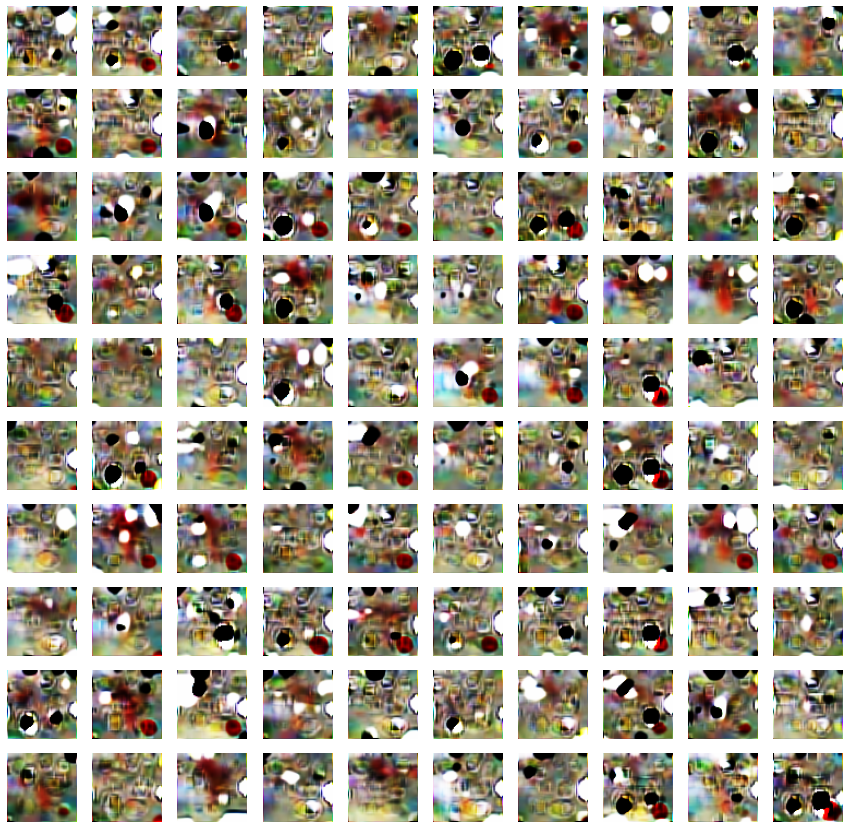

In [ ]:
from matplotlib import pyplot
 
# plot the generated images
def create_plot(examples, n):
    pyplot.figure(figsize=(15,15))
    # plot images
    for i in range(n * n):
        # define subplot
        pyplot.subplot(n, n, 1 + i)
        # turn off axis
        pyplot.axis('off')
        # plot raw pixel data
        pyplot.imshow(examples[i, :, :])
    pyplot.show()
 
# generate images
latent_points, labels_input = generate_latent_points(100, 100)
# predict outputs
X = generator.predict([latent_points, labels_input])
# scale from [-1,1] to [0,1]
X = (X + 1) / 2.0
# plot the result
create_plot(X, 10)

In [ ]:
print("GAN:", gan_model.metrics_names)
print("Generator:", generator.metrics_names)
print("Discrimator:", discriminator.metrics_names)

GAN: ['loss', 'model_loss', 'model_1_loss']
Generator: []
Discrimator: ['loss', 'dense_loss', 'dense_1_loss']


In [ ]:
d_r = np.asarray(d_r)
d_f = np.asarray(d_f)
g = np.asarray(g)
bat_per_epo = int(dataset[0].shape[0] / 64)
print(bat_per_epo)

14


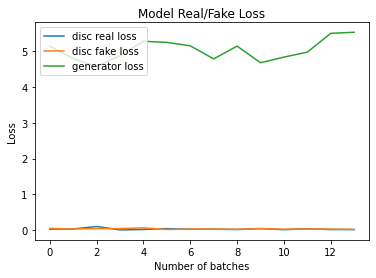

In [ ]:
# plot loss
plt.plot(d_r[:,0])
plt.plot(d_f[:,0])
plt.plot(g[:,0])
plt.title('Model Real/Fake Loss')
plt.ylabel('Loss')
plt.xlabel('Number of batches')
plt.legend(['disc real loss', 'disc fake loss', 'generator loss'], loc='upper left')
plt.show()

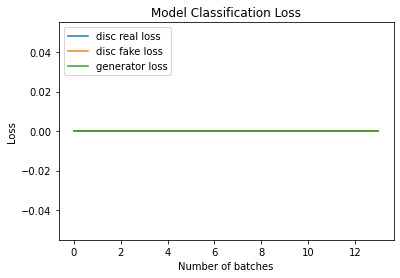

In [ ]:
# plot loss
plt.plot(d_r[:,1])
plt.plot(d_f[:,1])
plt.plot(g[:,1])
plt.title('Model Classification Loss')
plt.ylabel('Loss')
plt.xlabel('Number of batches')
plt.legend(['disc real loss', 'disc fake loss', 'generator loss'], loc='upper left')
plt.show()

In [ ]:
d_r_ep = np.asarray(d_r_ep)
d_f_ep = np.asarray(d_f_ep)
g_ep = np.asarray(g_ep)
print(d_r_ep.shape)
print(d_f_ep.shape)
print(g_ep.shape)

(999, 2)
(999, 2)
(999, 2)


In [ ]:
print(d_r_ep[:][0])

[0.08265468 0.04620892]


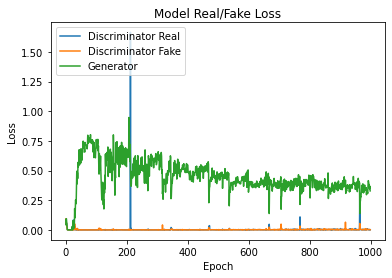

In [ ]:
# plot epoch loss
plt.plot(d_r_ep[:,0])
plt.plot(d_f_ep[:,0])
plt.plot(g_ep[:,0])
plt.title('Model Real/Fake Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Discriminator Real', 'Discriminator Fake', 'Generator'], loc='upper left')
plt.show()

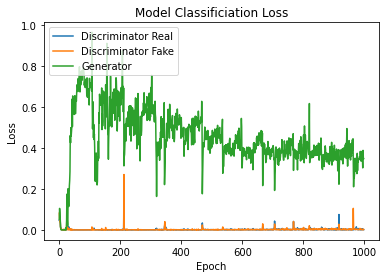

In [ ]:
# plot epoch loss
plt.plot(d_r_ep[:,1])
plt.plot(d_f_ep[:,1])
plt.plot(g_ep[:,1])
plt.title('Model Classificiation Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Discriminator Real', 'Discriminator Fake', 'Generator'], loc='upper left')
plt.show()

In [ ]:
from numpy import save
save('discriminator_real_loss.npy', d_r)
save('discriminator_fake_loss.npy', d_f)
save('generator_loss.npy', g)

<Figure size 1440x1440 with 0 Axes>

/usr/local/lib/python3.7/dist-packages/IPython/core/pylabtools.py:125: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


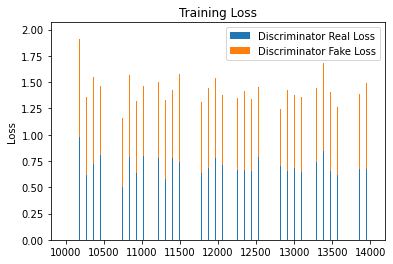

In [ ]:
width = 0.1
batch_num = np.arange(d_r.shape[0])

fig, ax = plt.subplots()
ax.bar(batch_num[10000:], d_r[10000:,0], width, label='Discriminator Real Loss')
ax.bar(batch_num[10000:], d_f[10000:,0], width, label='Discriminator Fake Loss', bottom=d_r[10000:,0])

ax.set_ylabel('Loss')
ax.set_title('Training Loss')
ax.legend()

plt.show()

In [ ]:
# load the saved model and make images 
!cp /content/gdrive/MyDrive/EEG2Image/GAN/models/model_14000.h5 ./

In [ ]:
# example of loading the generator model and generating images
from math import sqrt
from numpy import asarray
from numpy.random import randn
from keras.models import load_model
from matplotlib import pyplot
 
# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples, n_class):
	# generate points in the latent space
	x_input = randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	z_input = x_input.reshape(n_samples, latent_dim)
	# generate labels
	labels = asarray([n_class for _ in range(n_samples)])
	return [z_input, labels]
 
# create and save a plot of generated images
def save_plot(examples, n_examples):
	# plot images
	for i in range(n_examples):
		# define subplot
		pyplot.subplot(sqrt(n_examples), sqrt(n_examples), 1 + i)
		# turn off axis
		pyplot.axis('off')
		# plot raw pixel data
		pyplot.imshow(examples[i])
	pyplot.show()
	pyplot.savefig("horses.png")


In [ ]:
 # load model
generator = load_model('model_14000.h5')

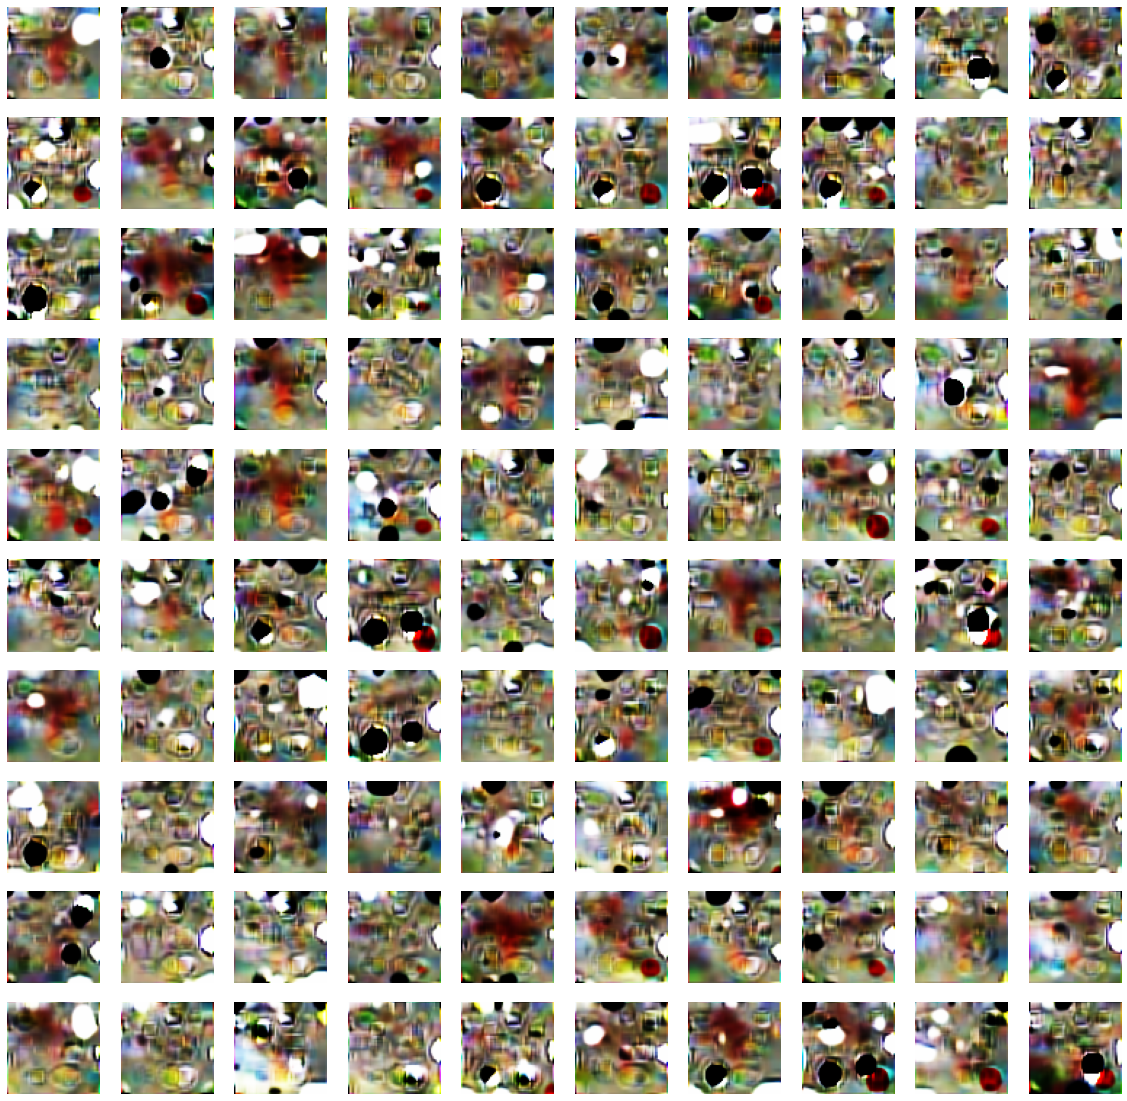

<Figure size 432x288 with 0 Axes>

In [ ]:
latent_dim = 100
n_examples = 100 # must be a square
n_class = 0 # horses
# generate images
latent_points, labels = generate_latent_points(latent_dim, n_examples, n_class)
# generate images
X  = generator.predict([latent_points, labels])
# scale from [-1,1] to [0,1]
X = (X + 1) / 2.0
# plot the result
pyplot.figure(figsize=(20,20))
save_plot(X, n_examples)

In [ ]:
!cp generated*.png ./gdrive/MyDrive/EEG2Image/GAN/images/4_28/
!cp horses.png ./gdrive/MyDrive/EEG2Image/GAN/images/4_28/

# AC-GAN Example Blog Post
https://machinelearningmastery.com/how-to-develop-an-auxiliary-classifier-gan-ac-gan-from-scratch-with-keras/

In [ ]:
# example of fitting an auxiliary classifier gan (ac-gan) on fashion mnsit
from numpy import zeros
from numpy import ones
from numpy import expand_dims
from numpy.random import randn
from numpy.random import randint
from keras.datasets.fashion_mnist import load_data
from keras.optimizers import Adam
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import BatchNormalization
from keras.layers import Dropout
from keras.layers import Embedding
from keras.layers import Activation
from keras.layers import Concatenate
from keras.initializers import RandomNormal
from matplotlib import pyplot

# define the standalone discriminator model
def define_discriminator(in_shape=(28,28,1), n_classes=10):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# image input
	in_image = Input(shape=in_shape)
	# downsample to 14x14
	fe = Conv2D(32, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(in_image)
	fe = LeakyReLU(alpha=0.2)(fe)
	fe = Dropout(0.5)(fe)
	# normal
	fe = Conv2D(64, (3,3), padding='same', kernel_initializer=init)(fe)
	fe = BatchNormalization()(fe)
	fe = LeakyReLU(alpha=0.2)(fe)
	fe = Dropout(0.5)(fe)
	# downsample to 7x7
	fe = Conv2D(128, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(fe)
	fe = BatchNormalization()(fe)
	fe = LeakyReLU(alpha=0.2)(fe)
	fe = Dropout(0.5)(fe)
	# normal
	fe = Conv2D(256, (3,3), padding='same', kernel_initializer=init)(fe)
	fe = BatchNormalization()(fe)
	fe = LeakyReLU(alpha=0.2)(fe)
	fe = Dropout(0.5)(fe)
	# flatten feature maps
	fe = Flatten()(fe)
	# real/fake output
	out1 = Dense(1, activation='sigmoid')(fe)
	# class label output
	out2 = Dense(n_classes, activation='softmax')(fe)
	# define model
	model = Model(in_image, [out1, out2])
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss=['binary_crossentropy', 'sparse_categorical_crossentropy'], optimizer=opt)
	return model

# define the standalone generator model
def define_generator(latent_dim, n_classes=10):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# label input
	in_label = Input(shape=(1,))
	# embedding for categorical input
	li = Embedding(n_classes, 50)(in_label)
	# linear multiplication
	n_nodes = 7 * 7
	li = Dense(n_nodes, kernel_initializer=init)(li)
	# reshape to additional channel
	li = Reshape((7, 7, 1))(li)
	# image generator input
	in_lat = Input(shape=(latent_dim,))
	# foundation for 7x7 image
	n_nodes = 384 * 7 * 7
	gen = Dense(n_nodes, kernel_initializer=init)(in_lat)
	gen = Activation('relu')(gen)
	gen = Reshape((7, 7, 384))(gen)
	# merge image gen and label input
	merge = Concatenate()([gen, li])
	# upsample to 14x14
	gen = Conv2DTranspose(192, (5,5), strides=(2,2), padding='same', kernel_initializer=init)(merge)
	gen = BatchNormalization()(gen)
	gen = Activation('relu')(gen)
	# upsample to 28x28
	gen = Conv2DTranspose(1, (5,5), strides=(2,2), padding='same', kernel_initializer=init)(gen)
	out_layer = Activation('tanh')(gen)
	# define model
	model = Model([in_lat, in_label], out_layer)
	return model

# define the combined generator and discriminator model, for updating the generator
def define_gan(g_model, d_model):
	# make weights in the discriminator not trainable
	for layer in d_model.layers:
		if not isinstance(layer, BatchNormalization):
			layer.trainable = False
	# connect the outputs of the generator to the inputs of the discriminator
	gan_output = d_model(g_model.output)
	# define gan model as taking noise and label and outputting real/fake and label outputs
	model = Model(g_model.input, gan_output)
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss=['binary_crossentropy', 'sparse_categorical_crossentropy'], optimizer=opt)
	return model

# load images
def load_real_samples():
	# load dataset
	(trainX, trainy), (_, _) = load_data()
	# expand to 3d, e.g. add channels
	X = expand_dims(trainX, axis=-1)
	# convert from ints to floats
	X = X.astype('float32')
	# scale from [0,255] to [-1,1]
	X = (X - 127.5) / 127.5
	print(X.shape, trainy.shape)
	return [X, trainy]

# select real samples
def generate_real_samples(dataset, n_samples):
	# split into images and labels
	images, labels = dataset
	# choose random instances
	ix = randint(0, images.shape[0], n_samples)
	# select images and labels
	X, labels = images[ix], labels[ix]
	# generate class labels
	y = ones((n_samples, 1))
	return [X, labels], y

# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples, n_classes=10):
	# generate points in the latent space
	x_input = randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	z_input = x_input.reshape(n_samples, latent_dim)
	# generate labels
	labels = randint(0, n_classes, n_samples)
	return [z_input, labels]

# use the generator to generate n fake examples, with class labels
def generate_fake_samples(generator, latent_dim, n_samples):
	# generate points in latent space
	z_input, labels_input = generate_latent_points(latent_dim, n_samples)
	# predict outputs
	images = generator.predict([z_input, labels_input])
	# create class labels
	y = zeros((n_samples, 1))
	return [images, labels_input], y

# generate samples and save as a plot and save the model
def summarize_performance(step, g_model, latent_dim, n_samples=100):
	# prepare fake examples
	[X, _], _ = generate_fake_samples(g_model, latent_dim, n_samples)
	# scale from [-1,1] to [0,1]
	X = (X + 1) / 2.0
	# plot images
	for i in range(100):
		# define subplot
		pyplot.subplot(10, 10, 1 + i)
		# turn off axis
		pyplot.axis('off')
		# plot raw pixel data
		pyplot.imshow(X[i, :, :, 0], cmap='gray_r')
	# save plot to file
	filename1 = 'generated_plot_%04d.png' % (step+1)
	pyplot.savefig(filename1)
	pyplot.close()
	# save the generator model
	filename2 = 'model_%04d.h5' % (step+1)
	g_model.save(filename2)
	print('>Saved: %s and %s' % (filename1, filename2))

# train the generator and discriminator
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=50, n_batch=64):
	# calculate the number of batches per training epoch
	bat_per_epo = int(dataset[0].shape[0] / n_batch)
	# calculate the number of training iterations
	n_steps = bat_per_epo * n_epochs
	# calculate the size of half a batch of samples
	half_batch = int(n_batch / 2)
	# manually enumerate epochs
	for i in range(n_steps):
		# get randomly selected 'real' samples
		[X_real, labels_real], y_real = generate_real_samples(dataset, half_batch)
		# update discriminator model weights
		_,d_r1,d_r2 = d_model.train_on_batch(X_real, [y_real, labels_real])
		# generate 'fake' examples
		[X_fake, labels_fake], y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
		# update discriminator model weights
		_,d_f,d_f2 = d_model.train_on_batch(X_fake, [y_fake, labels_fake])
		# prepare points in latent space as input for the generator
		[z_input, z_labels] = generate_latent_points(latent_dim, n_batch)
		# create inverted labels for the fake samples
		y_gan = ones((n_batch, 1))
		# update the generator via the discriminator's error
		_,g_1,g_2 = gan_model.train_on_batch([z_input, z_labels], [y_gan, z_labels])
		# summarize loss on this batch
		print('>%d, dr[%.3f,%.3f], df[%.3f,%.3f], g[%.3f,%.3f]' % (i+1, d_r1,d_r2, d_f,d_f2, g_1,g_2))
		# evaluate the model performance every 'epoch'
		if (i+1) % (bat_per_epo * 10) == 0:
			summarize_performance(i, g_model, latent_dim)



In [ ]:
# size of the latent space
latent_dim = 100
# create the discriminator
discriminator = define_discriminator()
# create the generator
generator = define_generator(latent_dim)
# create the gan
gan_model = define_gan(generator, discriminator)
# load image data
dataset = load_real_samples()
# train model
train(generator, discriminator, gan_model, dataset, latent_dim)

Streaming output truncated to the last 5000 lines.
>4832, dr[0.578,0.180], df[0.557,0.029], g[1.063,0.055]
>4833, dr[0.544,0.433], df[0.633,0.111], g[1.012,0.128]
>4834, dr[0.603,0.212], df[0.515,0.022], g[0.912,0.024]
>4835, dr[0.750,0.609], df[0.622,0.044], g[0.968,0.043]
>4836, dr[0.490,0.460], df[0.579,0.015], g[0.959,0.063]
>4837, dr[0.552,0.345], df[0.647,0.031], g[1.002,0.037]
>4838, dr[0.639,0.349], df[0.660,0.059], g[0.983,0.024]
>4839, dr[0.563,0.260], df[0.616,0.035], g[1.029,0.078]
>4840, dr[0.807,0.850], df[0.621,0.014], g[1.027,0.049]
>4841, dr[0.632,0.552], df[0.590,0.044], g[0.887,0.036]
>4842, dr[0.586,0.416], df[0.636,0.030], g[0.918,0.070]
>4843, dr[0.579,0.403], df[0.747,0.042], g[0.999,0.047]
>4844, dr[0.640,0.444], df[0.599,0.024], g[1.096,0.028]
>4845, dr[0.614,0.482], df[0.599,0.030], g[1.106,0.060]
>4846, dr[0.571,0.236], df[0.668,0.040], g[1.091,0.049]
>4847, dr[0.591,0.389], df[0.568,0.038], g[1.139,0.035]
>4848, dr[0.682,0.286], df[0.556,0.041], g[1.059,0.03

KeyboardInterrupt: ignored

# Generative Adversarial Network

**Discriminator**

In [ ]:
# example of training an unconditional gan on the fashion mnist dataset
from numpy import expand_dims
from numpy import zeros
from numpy import ones
from numpy.random import rand
from numpy.random import randn
from numpy.random import randint
from keras.datasets.fashion_mnist import load_data
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Dropout

**Reference:**
details of these models are taken from: https://machinelearningmastery.com/how-to-develop-a-generative-adversarial-network-for-a-cifar-10-small-object-photographs-from-scratch/

In [ ]:
# define the standalone discriminator model
def define_discriminator(in_shape=(64,64,3)):
    model = Sequential()
    # normal 
    model.add(Conv2D(64, (3,3), padding='same', input_shape=in_shape))
    model.add(LeakyReLU(alpha=0.2))
    # downsample
    model.add(Conv2D(128, (3,3), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    # downsample
    model.add(Conv2D(128, (3,3), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    # downsample; added an extra layer of downsampling to get the compressed image to 8x8
    model.add(Conv2D(256, (3,3), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    # classifier
    model.add(Flatten())
    model.add(Dropout(0.4))
    model.add(Dense(1, activation='sigmoid'))
    # compile model
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

In [ ]:
model = define_discriminator()

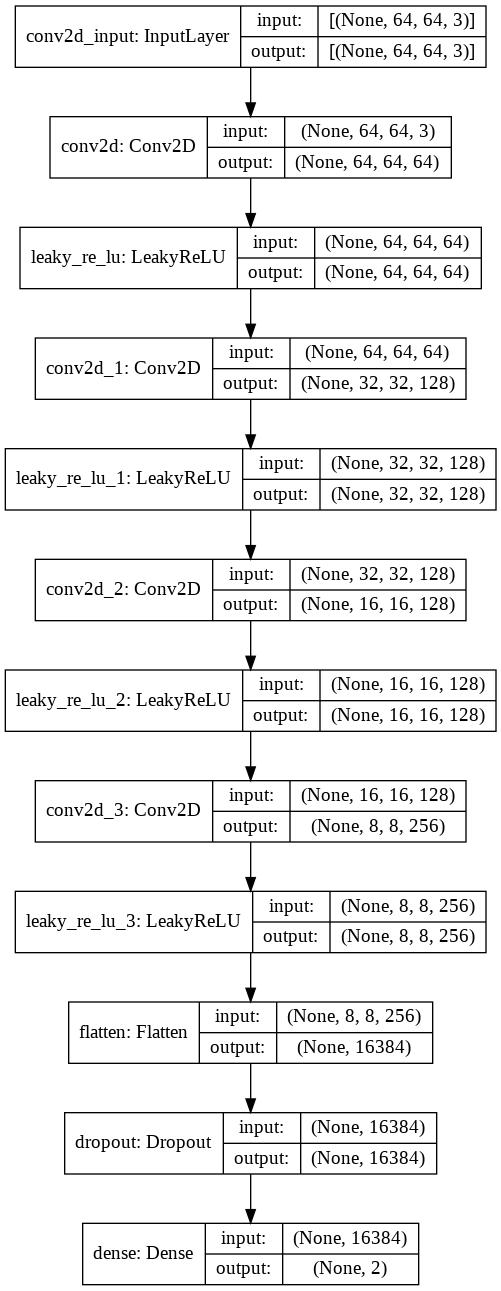

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='discriminator_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
# select real samples
def generate_real_samples(dataset, n_samples):
	# choose random instances
	ix = randint(0, dataset.shape[0], n_samples)
	# retrieve selected images
	X = dataset[ix]
	# generate 'real' class labels (1)
	y = ones((n_samples, 1))
	return X, y

In [ ]:
# generate fake images w random pixel values in range [0,1] then scale to [-1,1]
# this does not have a generator and was only used for testing the discriminator
def generate_fake_samples(n_samples):
	# generate uniform random numbers in [0,1]
	X = rand(64 * 64 * 3 * n_samples)
	# update to have the range [-1, 1]
	X = -1 + X * 2
	# reshape into a batch of color images
	X = X.reshape((n_samples, 64, 64, 3))
	# generate 'fake' class labels (0)
	y = zeros((n_samples, 1))
	return X, y

In [ ]:
X, y = generate_fake_samples(10)
print(np.amin(X))
print(np.amax(X))

-0.9999714967286162
0.9999865738700813


In [ ]:
def train_discriminator(model, dataset, n_iter=20, n_batch=128):
	half_batch = int(n_batch / 2)
	# manually enumerate epochs
	for i in range(n_iter):
		# get randomly selected 'real' samples
		X_real, y_real = generate_real_samples(dataset, half_batch)
		# update discriminator on real samples
		_, real_acc = model.train_on_batch(X_real, y_real)
		# generate 'fake' examples
		X_fake, y_fake = generate_fake_samples(half_batch)
		# update discriminator on fake samples
		_, fake_acc = model.train_on_batch(X_fake, y_fake)
		# summarize performance
		print('>%d real=%.0f%% fake=%.0f%%' % (i+1, real_acc*100, fake_acc*100))

In [ ]:
dataset, labels = load_image_net_data(scale=True)
# test discriminator
model = define_discriminator()
model.summary()

print("Training discriminator")
train_discriminator(model, dataset)

shape of the data: (40, 900, 12288)
classes: 40
images per class: 900
pixel values in images: 12288
shape after removing classes: (36000, 12288)
Converting data shape to 2D with 3 channels
scaling values to the range [-1, 1]
formatted shape: (36000, 64, 64, 3)
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_16 (Conv2D)           (None, 64, 64, 64)        1792      
_________________________________________________________________
leaky_re_lu_16 (LeakyReLU)   (None, 64, 64, 64)        0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 32, 32, 128)       73856     
_________________________________________________________________
leaky_re_lu_17 (LeakyReLU)   (None, 32, 32, 128)       0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 16, 16, 128)       14

**Generator**

In [ ]:
# example of defining the generator model
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.utils.vis_utils import plot_model

In [ ]:
# define the standalone generator model
def define_generator(latent_dim):
	model = Sequential()
	# foundation for 8x8 image
	n_nodes = 256 * 8 * 8
	model.add(Dense(n_nodes, input_dim=latent_dim))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Reshape((8, 8, 256)))
	# upsample to 16x16
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')) # stride is the amount of upsampling
	model.add(LeakyReLU(alpha=0.2))
	# upsample to 32x32
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# upsample to 64x64
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# output layer
	model.add(Conv2D(3, (3,3), activation='tanh', padding='same'))
	return model

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 16384)             1654784   
_________________________________________________________________
leaky_re_lu_20 (LeakyReLU)   (None, 16384)             0         
_________________________________________________________________
reshape (Reshape)            (None, 8, 8, 256)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 16, 16, 128)       524416    
_________________________________________________________________
leaky_re_lu_21 (LeakyReLU)   (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 32, 32, 128)       262272    
_________________________________________________________________
leaky_re_lu_22 (LeakyReLU)   (None, 32, 32, 128)      

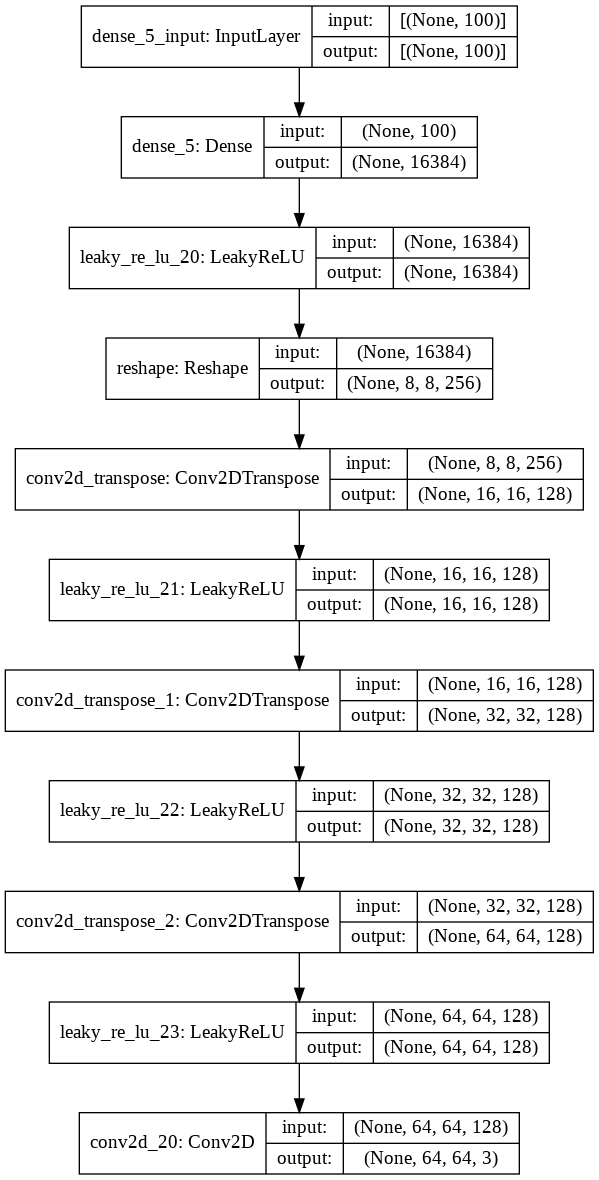

In [ ]:
# define the size of the latent space
latent_dim = 100
# define the generator model
model = define_generator(latent_dim)
# summarize the model
model.summary()
# plot the model
plot_model(model, to_file='generator_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
	# generate points in the latent space
	x_input = randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	x_input = x_input.reshape(n_samples, latent_dim)
	return x_input

In [ ]:
# use the generator to generate n fake examples, with class labels
def generate_fake_samples(g_model, latent_dim, n_samples):
	# generate points in latent space
	x_input = generate_latent_points(latent_dim, n_samples)
	# predict outputs
	X = g_model.predict(x_input)
	# create 'fake' class labels (0)
	y = zeros((n_samples, 1))
	return X, y

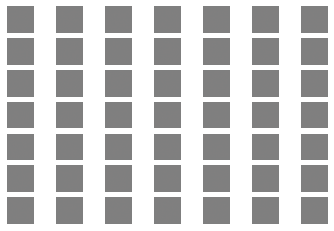

In [ ]:
# size of the latent space
latent_dim = 100
# define the discriminator model
model = define_generator(latent_dim)
# generate samples
n_samples = 49
X, _ = generate_fake_samples(model, latent_dim, n_samples)
# scale pixel values from [-1,1] to [0,1]
X = (X + 1) / 2.0
# plot the generated samples
for i in range(n_samples):
	# define subplot
	plt.subplot(7, 7, 1 + i)
	# turn off axis labels
	plt.axis('off')
	# plot single image
	plt.imshow(X[i])
# show the figure
plt.show()
# random grey images bc not trained

**Training the Generator Model**

In [ ]:
# define the combined generator and discriminator model, for updating the generator
def define_gan(g_model, d_model):
	# make weights in the discriminator not trainable
	d_model.trainable = False
	# connect them
	model = Sequential()
	# add generator
	model.add(g_model)
	# add the discriminator
	model.add(d_model)
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt)
	return model

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_10 (Sequential)   (None, 64, 64, 3)         2707203   
_________________________________________________________________
sequential_9 (Sequential)    (None, 1)                 534785    
Total params: 3,241,988
Trainable params: 2,707,203
Non-trainable params: 534,785
_________________________________________________________________


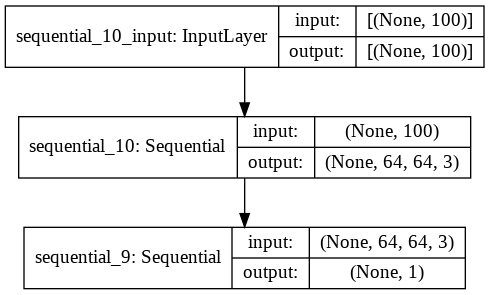

In [ ]:
# size of the latent space
latent_dim = 100
# create the discriminator
d_model = define_discriminator()
# create the generator
g_model = define_generator(latent_dim)
# create the gan
gan_model = define_gan(g_model, d_model)
# summarize gan model
gan_model.summary()
# plot gan model
plot_model(gan_model, to_file='gan_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
# create and save a plot of generated images
def save_plot(examples, epoch, n=7):
	# scale from [-1,1] to [0,1]
	examples = (examples + 1) / 2.0
	# plot images
	for i in range(n * n):
		# define subplot
		plt.subplot(n, n, 1 + i)
		# turn off axis
		plt.axis('off')
		# plot raw pixel data
		plt.imshow(examples[i])
	# save plot to file
	filename = 'generated_plot_e%03d.png' % (epoch+1)
	plt.savefig(filename)
	plt.close()
 
# evaluate the discriminator, plot generated images, save generator model
def summarize_performance(epoch, g_model, d_model, dataset, latent_dim, n_samples=150):
	# prepare real samples
	X_real, y_real = generate_real_samples(dataset, n_samples)
	# evaluate discriminator on real examples
	_, acc_real = d_model.evaluate(X_real, y_real, verbose=0)
	# prepare fake examples
	x_fake, y_fake = generate_fake_samples(g_model, latent_dim, n_samples)
	# evaluate discriminator on fake examples
	_, acc_fake = d_model.evaluate(x_fake, y_fake, verbose=0)
	# summarize discriminator performance
	print('>Accuracy real: %.0f%%, fake: %.0f%%' % (acc_real*100, acc_fake*100))
	# save plot
	save_plot(x_fake, epoch)
	# save the generator model tile file
	filename = 'generator_model_%03d.h5' % (epoch+1)
	g_model.save(filename)
 
# train the generator and discriminator
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=200, n_batch=128):
	bat_per_epo = int(dataset.shape[0] / n_batch)
	half_batch = int(n_batch / 2)
	# manually enumerate epochs
	for i in range(n_epochs):
		# enumerate batches over the training set
		for j in range(bat_per_epo):
			# get randomly selected 'real' samples
			X_real, y_real = generate_real_samples(dataset, half_batch)
			# update discriminator model weights
			d_loss1, _ = d_model.train_on_batch(X_real, y_real)
			# generate 'fake' examples
			X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
			# update discriminator model weights
			d_loss2, _ = d_model.train_on_batch(X_fake, y_fake)
			# prepare points in latent space as input for the generator
			X_gan = generate_latent_points(latent_dim, n_batch)
			# create inverted labels for the fake samples
			y_gan = ones((n_batch, 1))
			# update the generator via the discriminator's error
			g_loss = gan_model.train_on_batch(X_gan, y_gan)
			# summarize loss on this batch
			print('>%d, %d/%d, d1=%.3f, d2=%.3f g=%.3f' %
				(i+1, j+1, bat_per_epo, d_loss1, d_loss2, g_loss))
		# evaluate the model performance, sometimes
		if (i+1) % 10 == 0:
			summarize_performance(i, g_model, d_model, dataset, latent_dim)

In [ ]:
# execute training
# size of the latent space
latent_dim = 100
# create the discriminator
d_model = define_discriminator()
# create the generator
g_model = define_generator(latent_dim)
# create the gan
gan_model = define_gan(g_model, d_model)
# load image data
dataset, _ = load_image_net_data()
# train model
train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs= 20)

Streaming output truncated to the last 5000 lines.
>3, 61/281, d1=0.518, d2=0.591 g=1.168
>3, 62/281, d1=0.556, d2=0.580 g=1.219
>3, 63/281, d1=0.457, d2=0.504 g=1.220
>3, 64/281, d1=0.580, d2=0.525 g=1.164
>3, 65/281, d1=0.481, d2=0.671 g=1.111
>3, 66/281, d1=0.547, d2=0.730 g=1.257
>3, 67/281, d1=0.757, d2=0.766 g=1.324
>3, 68/281, d1=0.595, d2=0.534 g=1.375
>3, 69/281, d1=0.614, d2=0.541 g=1.444
>3, 70/281, d1=0.584, d2=0.430 g=1.536
>3, 71/281, d1=0.531, d2=0.428 g=1.580
>3, 72/281, d1=0.446, d2=0.405 g=1.888
>3, 73/281, d1=0.473, d2=0.450 g=1.768
>3, 74/281, d1=0.418, d2=0.484 g=1.655
>3, 75/281, d1=0.389, d2=0.474 g=1.611
>3, 76/281, d1=0.471, d2=0.540 g=1.442
>3, 77/281, d1=0.478, d2=0.648 g=1.389
>3, 78/281, d1=0.428, d2=0.543 g=1.428
>3, 79/281, d1=0.570, d2=0.636 g=1.367
>3, 80/281, d1=0.496, d2=0.563 g=1.436
>3, 81/281, d1=0.539, d2=0.552 g=1.361
>3, 82/281, d1=0.578, d2=0.622 g=1.477
>3, 83/281, d1=0.605, d2=0.631 g=1.428
>3, 84/281, d1=0.533, d2=0.531 g=1.347
>3, 85/281, d

In [ ]:
gan_model.save("gan_model_020.h5")
d_model.save("discriminator_model_020.h5")

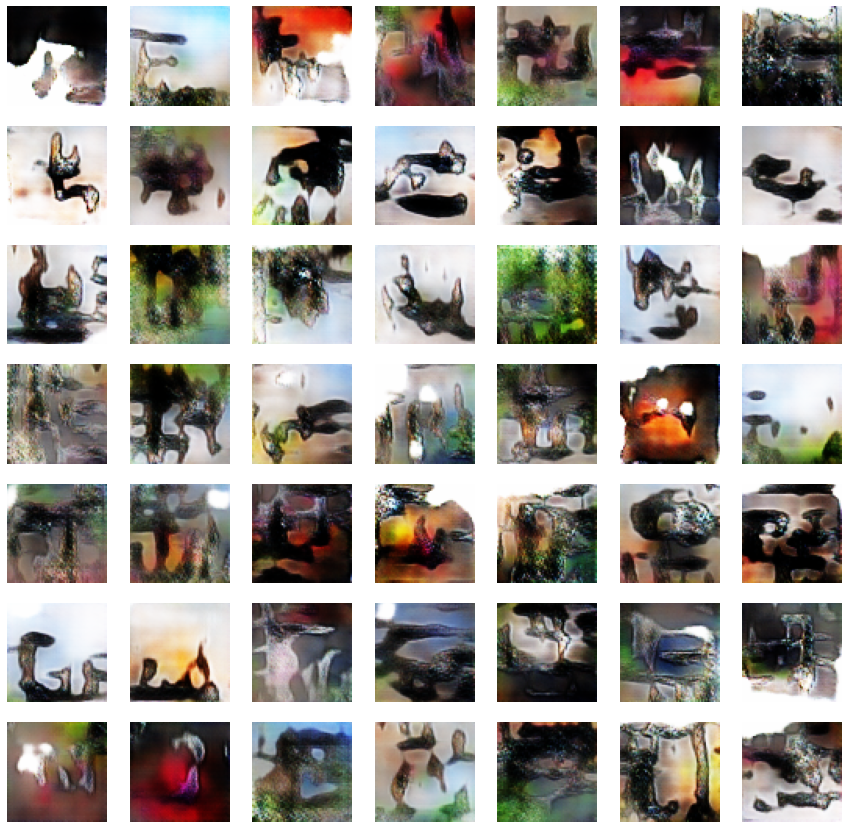

In [ ]:
from keras.models import load_model
# load the saved model and generate images
!cp /content/gdrive/MyDrive/EEG2Image/models/generator_model_020.h5 /content/
g_model = load_model('generator_model_020.h5')

# size of the latent space
latent_dim = 100
# generate samples
n_samples = 49
X, _ = generate_fake_samples(g_model, latent_dim, n_samples)
# scale pixel values from [-1,1] to [0,1]
X = (X + 1) / 2.0
plt.figure(figsize=(15, 15))
# plot the generated samples
for i in range(n_samples):
	# define subplot
	plt.subplot(7, 7, 1 + i)
	# turn off axis labels
	plt.axis('off')
	# plot single image
	plt.imshow(X[i])
# show the figure
plt.show()
# random grey images bc not trained

In [ ]:
# copy the models -> models folder
!cp /content/*.h5 /content/gdrive/MyDrive/EEG2Image/models/

# Trying example GAN from blogpost
Reference: https://machinelearningmastery.com/how-to-develop-a-conditional-generative-adversarial-network-from-scratch/

### Plan:
- reread blogpost
- get base code working (generate images from example dataset)
- generate images from our dataset (ImageNet)
    - only do 1 (not all 40) class of images
- generate images for all 40 classes
- generate images given the class

In [ ]:
# example of training an unconditional gan on the fashion mnist dataset
from numpy import expand_dims
from numpy import zeros
from numpy import ones
from numpy.random import randn
from numpy.random import randint
from keras.datasets.fashion_mnist import load_data
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Dropout

In [ ]:
# example of loading the fashion_mnist dataset
from keras.datasets.fashion_mnist import load_data
# load the images into memory
(trainX, trainy), (testX, testy) = load_data()
# summarize the shape of the dataset
print('Train', trainX.shape, trainy.shape)
print('Test', testX.shape, testy.shape)

4423680/4422102 [==============================] - 0s 0us/step
Train (60000, 28, 28) (60000,)
Test (10000, 28, 28) (10000,)


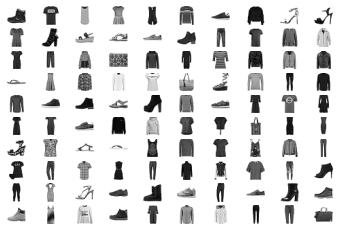

In [ ]:
# plot raw pixel data
#plt.imshow(trainX[1], cmap='gray')
#print(type(trainX[1][0][0]))
# values stored as uint8; our ImageNet classes should be saved the same way
# plot images from the training dataset
for i in range(100):
	# define subplot
	plt.subplot(10, 10, 1 + i)
	# turn off axis
	plt.axis('off')
	# plot raw pixel data
	plt.imshow(trainX[i], cmap='gray_r')
plt.show()

In [ ]:
# define the standalone discriminator model
def define_discriminator(in_shape=(28,28,1)): # see if you can simply call it with (64x64x3)
	model = Sequential()
	# downsample
	model.add(Conv2D(128, (3,3), strides=(2,2), padding='same', input_shape=in_shape))
	model.add(LeakyReLU(alpha=0.2))
	# downsample
	model.add(Conv2D(128, (3,3), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# classifier
	model.add(Flatten())
	model.add(Dropout(0.4))
	model.add(Dense(1, activation='sigmoid'))
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
	return model

In [ ]:
# define the standalone generator model
def define_generator(latent_dim):
	model = Sequential()
	# foundation for 7x7 image
	n_nodes = 128 * 7 * 7 # 128 copies of low resolution versions of the output image
	model.add(Dense(n_nodes, input_dim=latent_dim))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Reshape((7, 7, 128)))
	# upsample to 14x14
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# upsample to 28x28
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# generate
	model.add(Conv2D(1, (7,7), activation='tanh', padding='same'))
    # note: not compiled because this model is not trained directly
	return model

In [ ]:
# define the combined generator and discriminator model, for updating the generator
def define_gan(generator, discriminator):
	# make weights in the discriminator not trainable
	discriminator.trainable = False
	# connect them
	model = Sequential()
	# add generator
	model.add(generator)
	# add the discriminator
	model.add(discriminator)
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt)
	return model

In [ ]:
# load fashion mnist images
def load_real_samples():
	# load dataset
	(trainX, _), (_, _) = load_data()
	#print(trainX[0].shape) # initially just (28, 28)
	# expand to 3d, e.g. add channels
	X = expand_dims(trainX, axis=-1)
	#print(X[0].shape) # (28, 28, 1)
	#print(type(X[0][0][0][0])) # <class 'numpy.uint8'>
	# convert from ints to floats
	X = X.astype('float32')
	# scale from [0,255] to [-1,1]
	X = (X - 127.5) / 127.5
	return X

In [ ]:
samples = load_real_samples()
print(samples.shape)

(60000, 28, 28, 1)


In [ ]:
# select real samples
def generate_real_samples(dataset, n_samples):
	# choose random instances
	ix = randint(0, dataset.shape[0], n_samples)
	# select images
	X = dataset[ix]
	# generate class labels
	y = ones((n_samples, 1))
	return X, y

In [ ]:
# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
	# generate points in the latent space
	x_input = randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	x_input = x_input.reshape(n_samples, latent_dim)
	return x_input

In [ ]:
# use the generator to generate n fake examples, with class labels
def generate_fake_samples(generator, latent_dim, n_samples):
	# generate points in latent space
	x_input = generate_latent_points(latent_dim, n_samples)
	# predict outputs
	X = generator.predict(x_input)
	# create class labels
	y = zeros((n_samples, 1))
	return X, y

In [ ]:
# train the generator and discriminator
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=20, n_batch=128):
	bat_per_epo = int(dataset.shape[0] / n_batch)
	half_batch = int(n_batch / 2)
	# manually enumerate epochs
	for i in range(n_epochs):
		# enumerate batches over the training set
		for j in range(bat_per_epo):
			# get randomly selected 'real' samples
			X_real, y_real = generate_real_samples(dataset, half_batch)
			# update discriminator model weights
			d_loss1, _ = d_model.train_on_batch(X_real, y_real)
			# generate 'fake' examples
			X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
			# update discriminator model weights
			d_loss2, _ = d_model.train_on_batch(X_fake, y_fake)
			# prepare points in latent space as input for the generator
			X_gan = generate_latent_points(latent_dim, n_batch)
			# create inverted labels for the fake samples
			y_gan = ones((n_batch, 1))
			# update the generator via the discriminator's error
			g_loss = gan_model.train_on_batch(X_gan, y_gan)
			# summarize loss on this batch
			print('>%d, %d/%d, d1=%.3f, d2=%.3f g=%.3f' %
				(i+1, j+1, bat_per_epo, d_loss1, d_loss2, g_loss))
	# save the generator model
	g_model.save('generator.h5')

In [ ]:
# call all helper functions and execute training
# size of the latent space
latent_dim = 100
# create the discriminator
discriminator = define_discriminator()
# create the generator
generator = define_generator(latent_dim)
# create the gan
gan_model = define_gan(generator, discriminator)
# load image data
dataset = load_real_samples()
# train model
train(generator, discriminator, gan_model, dataset, latent_dim)

Streaming output truncated to the last 5000 lines.
>10, 149/468, d1=0.690, d2=0.692 g=0.728
>10, 150/468, d1=0.722, d2=0.685 g=0.726
>10, 151/468, d1=0.715, d2=0.700 g=0.720
>10, 152/468, d1=0.712, d2=0.689 g=0.718
>10, 153/468, d1=0.697, d2=0.686 g=0.731
>10, 154/468, d1=0.701, d2=0.681 g=0.733
>10, 155/468, d1=0.705, d2=0.667 g=0.731
>10, 156/468, d1=0.688, d2=0.685 g=0.728
>10, 157/468, d1=0.686, d2=0.703 g=0.718
>10, 158/468, d1=0.685, d2=0.704 g=0.712
>10, 159/468, d1=0.695, d2=0.697 g=0.719
>10, 160/468, d1=0.710, d2=0.700 g=0.711
>10, 161/468, d1=0.693, d2=0.700 g=0.725
>10, 162/468, d1=0.703, d2=0.695 g=0.731
>10, 163/468, d1=0.701, d2=0.687 g=0.719
>10, 164/468, d1=0.694, d2=0.667 g=0.729
>10, 165/468, d1=0.690, d2=0.692 g=0.728
>10, 166/468, d1=0.702, d2=0.695 g=0.716
>10, 167/468, d1=0.696, d2=0.702 g=0.717
>10, 168/468, d1=0.691, d2=0.711 g=0.712
>10, 169/468, d1=0.698, d2=0.686 g=0.728
>10, 170/468, d1=0.697, d2=0.681 g=0.719
>10, 171/468, d1=0.705, d2=0.700 g=0.703
>10, 1

In [ ]:
# save the model to models folder
!ls /content/gdrive/MyDrive/EEG2Image/models/
!ls /content/

generator.h5  lstm_21_test_acc
gdrive	image_mapping.npy  sample_data


In [ ]:
# copy the model -> models folder
!cp /content/generator.h5 /content/gdrive/MyDrive/EEG2Image/models/

In [ ]:
# copy the model from models folder to local
!cp /content/gdrive/MyDrive/EEG2Image/models/generator.h5 /content/

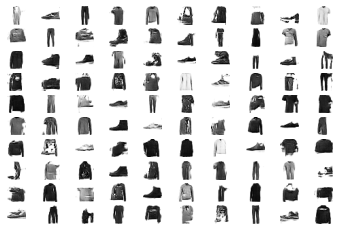

In [ ]:
# example of loading the generator model and generating images
from keras.models import load_model
from numpy.random import randn
from matplotlib import pyplot
 
# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
	# generate points in the latent space
	x_input = randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	x_input = x_input.reshape(n_samples, latent_dim)
	return x_input
 
# create and save a plot of generated images (reversed grayscale)
def show_plot(examples, n):
	# plot images
	for i in range(n * n):
		# define subplot
		pyplot.subplot(n, n, 1 + i)
		# turn off axis
		pyplot.axis('off')
		# plot raw pixel data
		pyplot.imshow(examples[i, :, :, 0], cmap='gray_r')
	pyplot.show()
 
# load model
model = load_model('generator.h5')
# generate images
latent_points = generate_latent_points(100, 100)
# generate images
X = model.predict(latent_points)
# plot the result
show_plot(X, 10)